In [1]:
from dataclasses import dataclass

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.autolayout"] = True

In [2]:
from paths_image import PathsImage

@dataclass
class Path:
    name: str
    xyz: np.array
    lat: np.array
    lon: np.array
    sections = property(lambda self: self.lat.shape[0])

PATHS: dict[str, Path] = {}

R_EQUAT = 2440.5  # Equatorial radius (semi-major)
R_POLAR = 2438.3  # Polar radius (semi-minor)
R_CIRC = (R_EQUAT + R_POLAR) / 2  # Radius to use for circular calcs

for path_name, raw_points in PathsImage.PATHS.items():
    points = np.array(raw_points).T

    # Centre x-y and flip y b/c pixels go downwards
    points[0] -= PathsImage.CENTRE[0]
    points[1] = -(points[1] - PathsImage.CENTRE[1])
    # Scale from pixels to kilometres
    points = points * (R_CIRC / PathsImage.RADIUS)

    # Convert from x-y to latitude, longitude
    lat_rad = -np.arccos(np.hypot(points[0], points[1]) / R_CIRC)
    lon_rad = np.arctan2(points[1], points[0])
    lat, lon = np.rad2deg(lat_rad), np.rad2deg(lon_rad)

    # Save for later
    xyz = np.array([points[0], points[1], R_CIRC * np.sin(lat_rad)])
    path = Path(path_name, xyz, lat, lon)
    PATHS[path_name] = path

## Plot Path x-y Coordinates

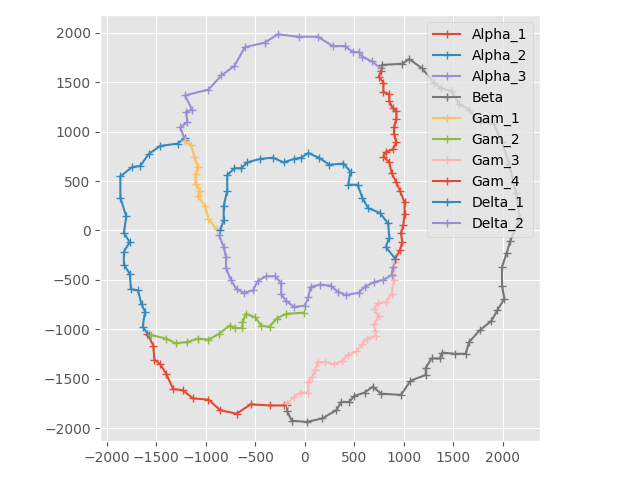

In [3]:
fig, ax = plt.subplots(1)
ax.set_aspect("equal")

for name, path in PATHS.items():
    ax.plot(path.xyz[0], path.xyz[1], "-+", label=name)
    # ax[0].plot(path.lat, "-+", label=name)
    # ax[1].plot(path.lon, "-+", label=name)

ax.legend()

## Plot 3D Plot of Paths

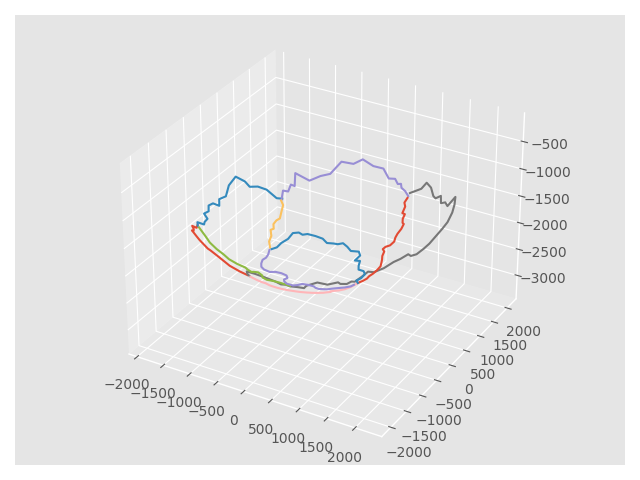

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for name, path in PATHS.items():
    ax.plot3D(path.xyz[0], path.xyz[1], path.xyz[2])

ax.set_aspect("equal")

## Total Path Distance

In [5]:
def haversine_distance(lat_1, lon_1, lat_2, lon_2):
    lat_1, lon_1 = np.deg2rad(lat_1), np.deg2rad(lon_1)
    lat_2, lon_2 = np.deg2rad(lat_2), np.deg2rad(lon_2)
    a = np.sin((lat_2 - lat_1) / 2) ** 2
    b = np.sin((lon_2 - lon_1) / 2) ** 2
    c = (a + b * np.cos(lat_1) * np.cos(lat_2))
    return R_CIRC * 2 * np.arctan2(np.sqrt(c), np.sqrt(1 - c))

def total_path_distance(path):
    tot_d = 0
    for i in range(1, path.sections - 1):
        d = haversine_distance(path.lat[i - 1], path.lon[i - 1], path.lat[i], path.lon[i])
        tot_d += d
    return tot_d

print("Total Path Distances [km]:")
for name, path in PATHS.items():
    tot_d = total_path_distance(path)
    print(f"  {name}: {tot_d:.2f} [km]")

Total Path Distances [km]:
  Alpha_1: 1945.73 [km]
  Alpha_2: 2737.72 [km]
  Alpha_3: 3069.78 [km]
  Beta: 7068.61 [km]
  Gam_1: 1003.99 [km]
  Gam_2: 1834.32 [km]
  Gam_3: 2214.13 [km]
  Gam_4: 2199.04 [km]
  Delta_1: 3003.27 [km]
  Delta_2: 2658.93 [km]
